# **APF**

In [44]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib
from IPython.display import HTML
from numpy.random import default_rng

In [87]:
matplotlib.rcParams['animation.embed_limit'] = 100

In [88]:
# --- Simulation parameters ---
dt = 0.05
T = 30.0
steps = int(T / dt)

# --- Environment setup ---
goal = np.array([10.0, 0.0])

start_rect = np.array([[0, -0.5], [1, -0.5], [1, 0.5], [0, 0.5]])
obstacle_start = np.array([3.0, 0.0])
obstacle_end = np.array([8.0, 0.0])
obstacle_speed = (obstacle_end - obstacle_start) / T
obstacle_radius = 0.4

# Robot parameters
wheel_base = 0.2
mu = 0.1
mu_omega = 0.08
sigma_v = 0.06
sigma_omega = 0.04

# Potential field parameters
k_att = 0.5
k_vert0 = 0.4
k_horiz0 = 0.6
alpha_v = 0.5
alpha_h = 0.6
k_rep = 8.0
d0 = 1.2
k_vortex = 7.2

# Initial state
rng = default_rng()
agent_init = np.array([
    rng.uniform(start_rect[0, 0], start_rect[1, 0]),
    rng.uniform(start_rect[0, 1], start_rect[2, 1])
])
state = np.array([agent_init[0], agent_init[1], 0.0])

trajectory = []
speed_profile = []
slip_long = []
slip_lat = []

In [89]:
def obstacle_pos(t):
    return obstacle_start + (obstacle_end - obstacle_start) * min(t / T, 1.0)

# Vectorized forces
def attractive_force_vec(qs, goal, radius=2.0):
    diff = goal - qs
    dist = np.linalg.norm(diff, axis=1)
    forces = np.zeros_like(diff)
    inside_mask = dist <= radius
    forces[inside_mask] = k_att * diff[inside_mask]
    return forces

def vertical_force_vec(qs, v):
    y = qs[:,1]
    k_vert = k_vert0 * (1 + alpha_v * v)
    Fy = np.where(y > 0, -k_vert * np.abs(y), np.where(y < 0, k_vert * np.abs(y), 0))
    Fx = np.zeros_like(Fy)
    return np.stack([Fx, Fy], axis=1)

def horizontal_force_vec(qs, v):
    k_horiz = k_horiz0 * (1 + alpha_h * v)
    Fx = k_horiz * (10 - qs[:,0]) / 10
    Fy = np.zeros_like(Fx)
    return np.stack([Fx, Fy], axis=1)

def repulsive_force_vec(qs, q_o):
    rel = qs - q_o
    d = np.linalg.norm(rel, axis=1)
    mask = d <= d0
    F = np.zeros_like(rel)
    d_safe = np.where(d == 0, 1e-6, d)
    grad = rel / d_safe[:, None]
    F[mask] = k_rep * (1/d_safe[mask] - 1/d0)[:, None] * grad[mask]
    return F

def vortex_force_vec(qs, q_o):
    rel = qs - q_o
    d = np.linalg.norm(rel, axis=1)
    mask = d <= d0
    perp = np.stack([rel[:,1], -rel[:,0]], axis=1)
    F = np.zeros_like(rel)
    d_safe = np.where(d == 0, 1e-6, d)
    above_mask = qs[:,1] > 0
    below_mask = ~above_mask
    F[mask & above_mask] = k_vortex * perp[mask & above_mask] / (d_safe[mask & above_mask]**2)[:, None]
    F[mask & below_mask] = -k_vortex * perp[mask & below_mask] / (d_safe[mask & below_mask]**2)[:, None]
    return F

In [90]:
def diff_drive_update(state, v_cmd, omega_cmd):
    x, y, theta = state
    v = v_cmd - mu * v_cmd * dt
    omega = omega_cmd - mu_omega * omega_cmd * dt
    slip_v = np.random.normal(0, sigma_v)
    slip_omega = np.random.normal(0, sigma_omega)
    v += slip_v
    omega += slip_omega
    dx = v * np.cos(theta) * dt
    dy = v * np.sin(theta) * dt
    dtheta = omega * dt
    return np.array([x + dx, y + dy, theta + dtheta]), v, omega, slip_v, slip_omega

In [91]:
# --- Simulation loop ---
# Initialize v_cmd outside the loop, before simulation starts
v_cmd = 0.0
v_cmd_max = 1.0  # max speed scaling factor
acceleration = 0.02  # small increment per time step for smooth increase

for step in range(steps):
    t = step * dt
    q = state[:2]
    theta = state[2]
    obs_pos = obstacle_pos(t)

    F_att = -k_att * (q - goal)
    speed = np.linalg.norm(F_att)
    F_vert = vertical_force_vec(q.reshape(1,2), speed)[0]
    F_horiz = horizontal_force_vec(q.reshape(1,2), speed)[0]
    F_rep = repulsive_force_vec(q.reshape(1,2), obs_pos)[0]
    F_vort = vortex_force_vec(q.reshape(1,2), obs_pos)[0]
    F_total = F_att + F_vert + F_horiz + F_rep + F_vort


    force_mag = np.linalg.norm(F_total)
    desired_speed = v_cmd_max * np.tanh(0.5 * force_mag)

    # Smooth speed update: increment or decrement gradually toward desired speed
    if v_cmd < desired_speed:
        v_cmd = min(v_cmd + acceleration, desired_speed)
    else:
        v_cmd = max(v_cmd - acceleration, desired_speed)

    target_theta = np.arctan2(F_total[1], F_total[0])
    theta_diff = (target_theta - theta + np.pi) % (2 * np.pi) - np.pi
    omega_cmd = np.clip(1.5 * theta_diff, -2.0, 2.0)

    state, v_act, omega_act, sl_v, sl_omega = diff_drive_update(state, v_cmd, omega_cmd)

    trajectory.append(state.copy())
    speed_profile.append(v_act)
    slip_long.append(sl_v)
    slip_lat.append(sl_omega)

    if np.linalg.norm(state[:2] - goal) < 0.2:
        break

trajectory = np.array(trajectory)
speed_profile = np.array(speed_profile)
slip_long = np.array(slip_long)
slip_lat = np.array(slip_lat)

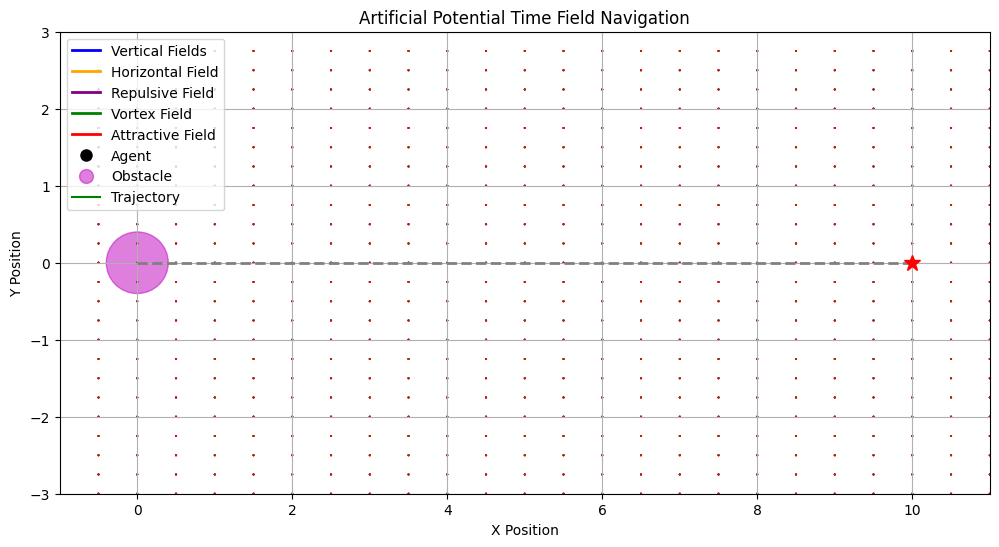

In [92]:
# --- Grid for vector field visualization ---
x_grid = np.linspace(-1, 11, 25)
y_grid = np.linspace(-3, 3, 25)
X, Y = np.meshgrid(x_grid, y_grid)
grid_points = np.stack([X.ravel(), Y.ravel()], axis=1)

# --- Setup figure and quivers ---
# --- Setup figure and quivers ---

fig, ax = plt.subplots(figsize=(12, 6))

# Plot static elements
ax.plot([0, 10], [0, 0], '--', color='gray', linewidth=2, label='Imaginary Line')
ax.plot(goal[0], goal[1], 'r*', markersize=12, label='Goal')
ax.set_xlim(-1, 11)
ax.set_ylim(-3, 3)
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Artificial Potential Time Field Navigation')
ax.grid(True)

# Plot agent and obstacle
agent_dot, = ax.plot([], [], 'ko', markersize=10, label='Agent')
obstacle_dot = plt.Circle((0, 0), obstacle_radius, color='m', alpha=0.5, label='Obstacle')
ax.add_patch(obstacle_dot)

traj_line, = ax.plot([], [], 'g-', linewidth=1.5, alpha=0.6, label='Trajectory')

# Initialize zero vectors for quivers
zero_vecs = np.zeros_like(X)

# Quivers for each field with distinct colors
quiv_vert = ax.quiver(X, Y, zero_vecs, zero_vecs, color='blue', scale=20, label='Vertical Fields')
quiv_horiz = ax.quiver(X, Y, zero_vecs, zero_vecs, color='orange', scale=20, label='Horizontal Field')
quiv_rep = ax.quiver(X, Y, zero_vecs, zero_vecs, color='purple', scale=20, label='Repulsive Field')
quiv_vort = ax.quiver(X, Y, zero_vecs, zero_vecs, color='green', scale=20, label='Vortex Field')
quiv_att = ax.quiver(X, Y, np.zeros_like(X), np.zeros_like(Y), color='red', scale=20, label='Attractive Field')

# Add legend manually for quivers (quiver objects don't add automatically)
from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], color='blue', lw=2, label='Vertical Fields'),
    Line2D([0], [0], color='orange', lw=2, label='Horizontal Field'),
    Line2D([0], [0], color='purple', lw=2, label='Repulsive Field'),
    Line2D([0], [0], color='green', lw=2, label='Vortex Field'),
    Line2D([0], [0], color='red', lw=2, label='Attractive Field'),
    Line2D([0], [0], marker='o', color='k', label='Agent', markersize=8, linestyle='None'),
    Line2D([0], [0], marker='o', color='m', label='Obstacle', markersize=10, linestyle='None', alpha=0.5),
    Line2D([0], [0], color='g', lw=1.5, label='Trajectory')
]
ax.legend(handles=legend_elements, loc='upper left')

In [51]:
# --- Animation function ---
def animate(i):
    agent_pos = trajectory[i, :2]
    t = i * dt
    obs_pos = obstacle_pos(t)

    # Update agent and obstacle positions
    agent_dot.set_data([agent_pos[0]], [agent_pos[1]])
    obstacle_dot.center = (obs_pos[0], obs_pos[1])
    traj_line.set_data(trajectory[:i+1, 0], trajectory[:i+1, 1])

    speed = speed_profile[i]

    # Compute vector fields at all grid points
    F_vert = vertical_force_vec(grid_points, speed)
    F_horiz = horizontal_force_vec(grid_points, speed)
    F_rep = repulsive_force_vec(grid_points, obs_pos)
    F_vort = vortex_force_vec(grid_points, obs_pos)
    F_att = attractive_force_vec(grid_points, goal, 2)

    # Scale factors for vector lengths (adjust these to scale arrows)
    vert_scale_factor = 1
    horiz_scale_factor = 1.0
    rep_scale_factor = 0.2
    vort_scale_factor = 0.2
    att_scale_factor = 1.0

    # Reshape vectors to grid shape and apply scaling
    U_vert = (F_vert[:,0] * vert_scale_factor).reshape(X.shape)
    V_vert = (F_vert[:,1] * vert_scale_factor).reshape(Y.shape)
    U_horiz = (F_horiz[:,0] * horiz_scale_factor).reshape(X.shape)
    V_horiz = (F_horiz[:,1] * horiz_scale_factor).reshape(Y.shape)
    U_rep = (F_rep[:,0] * rep_scale_factor).reshape(X.shape)
    V_rep = (F_rep[:,1] * rep_scale_factor).reshape(Y.shape)
    U_vort = (F_vort[:,0] * vort_scale_factor).reshape(X.shape)
    V_vort = (F_vort[:,1] * vort_scale_factor).reshape(Y.shape)
    U_att = (F_att[:,0] * att_scale_factor).reshape(X.shape)
    V_att = (F_att[:,1] * att_scale_factor).reshape(Y.shape)

    # Update quivers with scaled vectors
    quiv_vert.set_UVC(U_vert, V_vert)
    quiv_horiz.set_UVC(U_horiz, V_horiz)
    quiv_rep.set_UVC(U_rep, V_rep)
    quiv_vort.set_UVC(U_vort, V_vort)
    quiv_att.set_UVC(U_att, V_att)

    return agent_dot, obstacle_dot, traj_line, quiv_vert, quiv_horiz, quiv_rep, quiv_vort, quiv_att

ani = animation.FuncAnimation(fig, animate, frames=len(trajectory), interval=50, blit=True, repeat=False)

# Display animation in Jupyter/Colab
display(HTML(ani.to_jshtml()))

KeyboardInterrupt: 

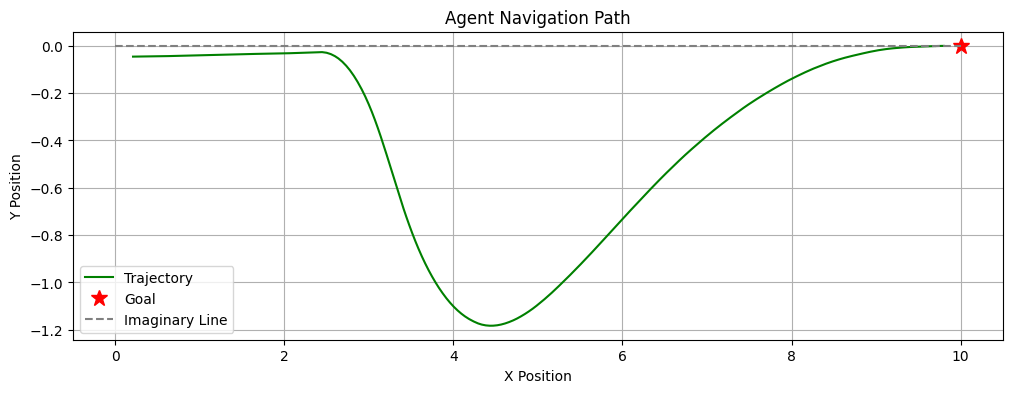

In [93]:
# --- Plot trajectory ---
plt.figure(figsize=(12, 4))
plt.plot(trajectory[:, 0], trajectory[:, 1], 'g-', label='Trajectory')
plt.plot(goal[0], goal[1], 'r*', markersize=12, label='Goal')
plt.plot([0, 10], [0, 0], '--', color='gray', label='Imaginary Line')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Agent Navigation Path')
plt.legend()
plt.grid(True)
plt.show()

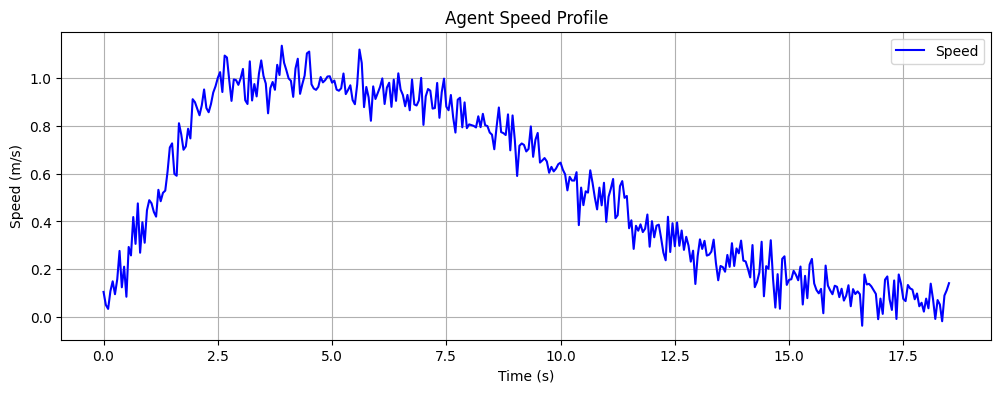

In [94]:
# --- Plot speed profile ---
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(speed_profile))*dt, speed_profile, 'b-', label='Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Agent Speed Profile')
plt.legend()
plt.grid(True)
plt.show()

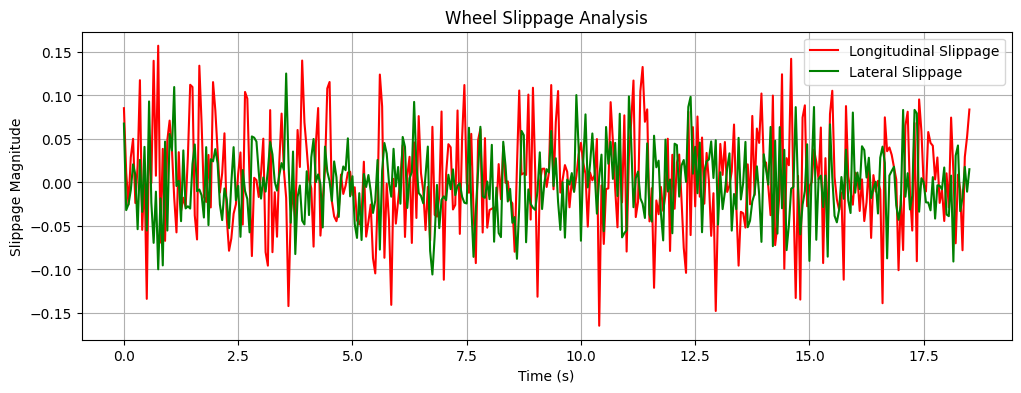

In [95]:
# --- Plot slippage ---
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(slip_long))*dt, slip_long, 'r-', label='Longitudinal Slippage')
plt.plot(np.arange(len(slip_lat))*dt, slip_lat, 'g-', label='Lateral Slippage')
plt.xlabel('Time (s)')
plt.ylabel('Slippage Magnitude')
plt.title('Wheel Slippage Analysis')
plt.legend()
plt.grid(True)
plt.show()

# **Backstepping**

In [96]:
# --- Robot and Motor Parameters ---
m = 2.0           # mass (kg)
r = 0.05          # wheel radius (m)
w = 0.2           # wheelbase (m)
gamma = 0.15      # motor time constant (s)
dt = 0.05

In [97]:
# --- Reference Trajectory ---
xy = trajectory[:, :2]
N = len(xy)

In [98]:
# Reference velocities and accelerations
v_d = np.zeros(N)
omega_d = np.zeros(N)
dot_v_d = np.zeros(N)
dot_omega_d = np.zeros(N)
theta_d = np.zeros(N)

In [99]:
# --- Compute desired velocities and accelerations ---
for i in range(1, N):
    dx = xy[i,0] - xy[i-1,0]
    dy = xy[i,1] - xy[i-1,1]
    v_d[i] = np.hypot(dx, dy) / dt
    theta_d[i] = np.arctan2(dy, dx)
    if i > 1:
        dtheta = (theta_d[i] - theta_d[i-1] + np.pi) % (2 * np.pi) - np.pi
        omega_d[i] = dtheta / dt
        dot_v_d[i] = (v_d[i] - v_d[i-1]) / dt
        dot_omega_d[i] = (omega_d[i] - omega_d[i-1]) / dt

In [100]:
# --- Ensure initial desired speed is zero ---
v_d[0] = 0.0

In [101]:
# --- Backstepping Controller Gains ---
k1 = 10.0  # speed error gain
k2 = 10.0  # angular speed error gain
k3 = 8.0   # accel error gain
k4 = 8.0   # ang accel error gain

# --- Simulation State Arrays ---
state = np.zeros((N, 7)) # [x, y, theta, v, omega, tau_L, tau_R]
state[0, :3] = [xy[0,0], xy[0,1], theta_d[0]] # initial pose
v = v_d[0]
omega = omega_d[0]
tau_L = 0.0
tau_R = 0.0

# --- Data Storage ---
v_real = []
omega_real = []
dot_v_real = []
dot_omega_real = []
tau_L_arr = []
tau_R_arr = []
lyap_arr = []
xy_real = []

In [102]:
slip_v = np.random.normal(0, sigma_v)
slip_omega = np.random.normal(0, sigma_omega)

In [103]:
for i in range(1, N):
    # --- Reference ---
    v_ref = v_d[i]
    omega_ref = omega_d[i]
    dot_v_ref = dot_v_d[i]
    dot_omega_ref = dot_omega_d[i]

    # --- Errors ---
    e_v = v - v_ref
    e_omega = omega - omega_ref

    # --- Wheel torques to linear/angular accel ---
    dot_v = (r/(2*m)) * (tau_L + tau_R) + slip_v
    dot_omega = (r/(m*w)) * (tau_R - tau_L) +slip_omega

    # --- Acceleration errors ---
    e_dot_v = dot_v - dot_v_ref
    e_dot_omega = dot_omega - dot_omega_ref

    # --- Lyapunov Function ---
    V = 0.5*e_v**2 + 0.5*e_omega**2 + 0.5*e_dot_v**2 + 0.5*e_dot_omega**2
    lyap_arr.append(V)

    # --- Backstepping Control Law for tau derivatives ---
    # Virtual controls for desired accels (backstepping)
    v_dot_des = dot_v_ref - k1*e_v
    omega_dot_des = dot_omega_ref - k2*e_omega

    # Convert to desired torques
    tau_sum_des = (2*m/r) * v_dot_des
    tau_diff_des = (m*w/r) * omega_dot_des

    tau_L_des = 0.5 * (tau_sum_des - tau_diff_des)
    tau_R_des = 0.5 * (tau_sum_des + tau_diff_des)

    # Backstepping for torque dynamics: a = gamma*(tau_des - tau) - k3*e_dot_v, -k4*e_dot_omega
    a_L = gamma * (tau_L_des - tau_L) - k3*e_dot_v
    a_R = gamma * (tau_R_des - tau_R) - k4*e_dot_omega

    # --- Motor torque update (first-order lag) ---
    tau_L += dt * (1/gamma) * (-tau_L + a_L)
    tau_R += dt * (1/gamma) * (-tau_R + a_R)

    # --- Robot dynamics update (no slippage for control) ---
    v = v + dot_v * dt
    omega = omega + dot_omega * dt
    theta = state[i-1,2] + omega * dt
    x = state[i-1,0] + v * np.cos(theta) * dt
    y = state[i-1,1] + v * np.sin(theta) * dt

    state[i] = [x, y, theta, v, omega, tau_L, tau_R]

    # --- Store for plots ---
    v_real.append(v)
    omega_real.append(omega)
    dot_v_real.append(dot_v)
    dot_omega_real.append(dot_omega)
    tau_L_arr.append(tau_L)
    tau_R_arr.append(tau_R)
    xy_real.append([x, y])

In [104]:
# Convert lists to arrays
v_real = np.array(v_real)
omega_real = np.array(omega_real)
dot_v_real = np.array(dot_v_real)
dot_omega_real = np.array(dot_omega_real)
tau_L_arr = np.array(tau_L_arr)
tau_R_arr = np.array(tau_R_arr)
lyap_arr = np.array(lyap_arr)
xy_real = np.array(xy_real)

In [105]:
t = np.arange(N-1)*dt

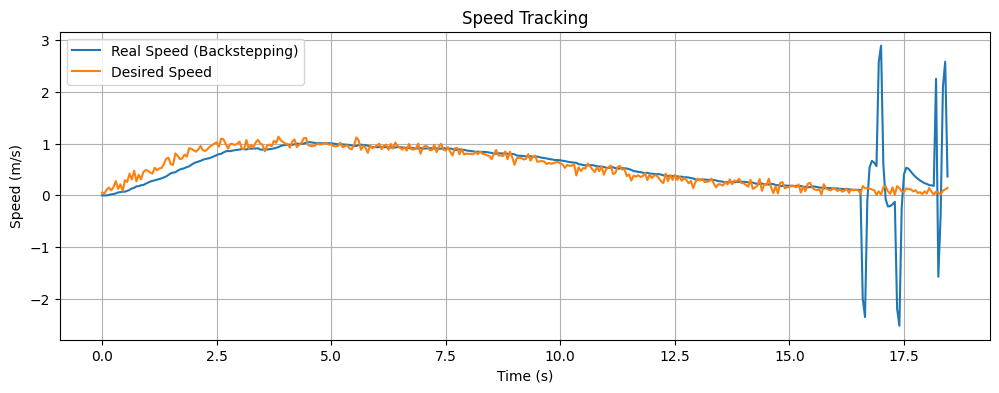

In [106]:
plt.figure(figsize=(12,4))
plt.plot(t, v_real, label='Real Speed (Backstepping)')
plt.plot(t, v_d[1:], label='Desired Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Speed Tracking')
plt.legend()
plt.grid(True)
plt.show()

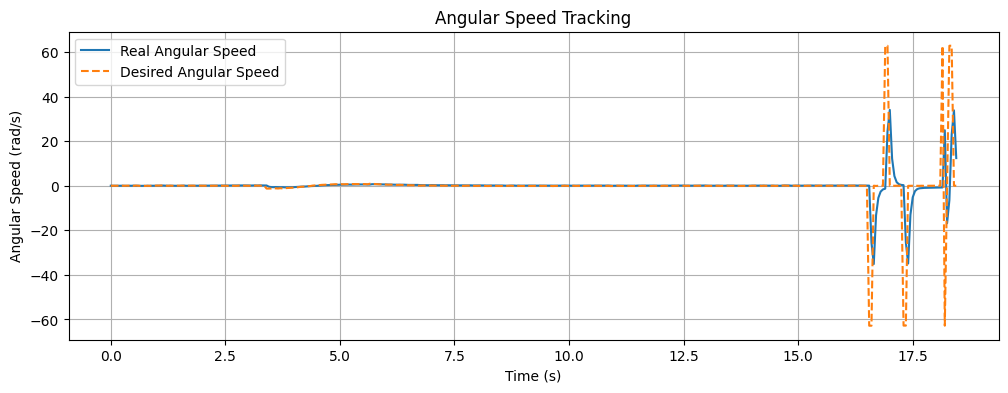

In [107]:
plt.figure(figsize=(12,4))
plt.plot(t, omega_real, label='Real Angular Speed')
plt.plot(t, omega_d[1:], label='Desired Angular Speed', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Angular Speed (rad/s)')
plt.title('Angular Speed Tracking')
plt.legend()
plt.grid(True)
plt.show()

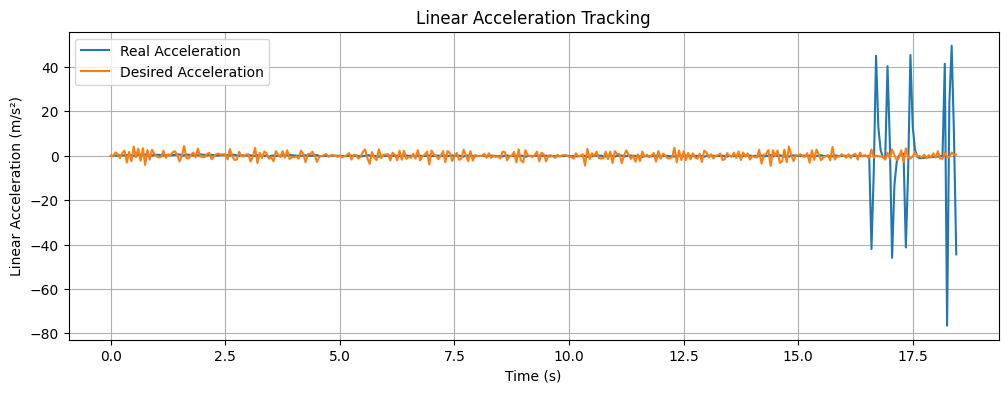

In [108]:
plt.figure(figsize=(12,4))
plt.plot(t, dot_v_real, label='Real Acceleration')
plt.plot(t, dot_v_d[1:], label='Desired Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Linear Acceleration (m/s²)')
plt.title('Linear Acceleration Tracking')
plt.legend()
plt.grid(True)
plt.show()

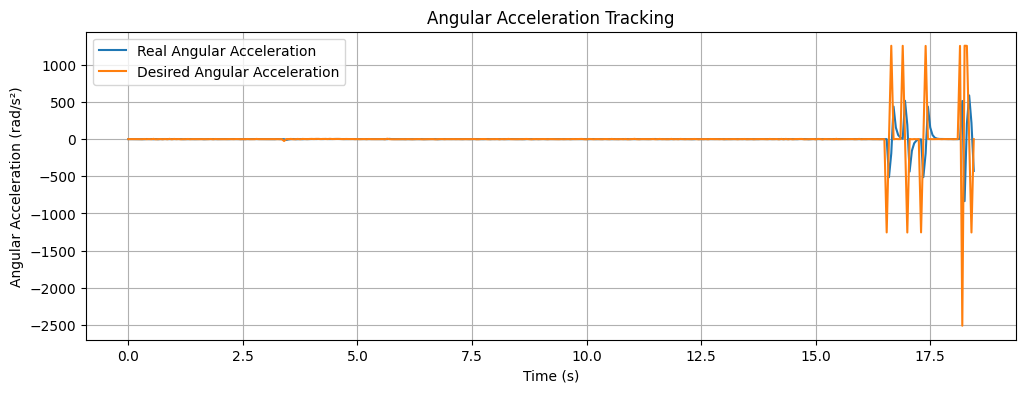

In [109]:
plt.figure(figsize=(12,4))
plt.plot(t, dot_omega_real, label='Real Angular Acceleration')
plt.plot(t, dot_omega_d[1:], label='Desired Angular Acceleration')
plt.xlabel('Time (s)')
plt.ylabel('Angular Acceleration (rad/s²)')
plt.title('Angular Acceleration Tracking')
plt.legend()
plt.grid(True)
plt.show()

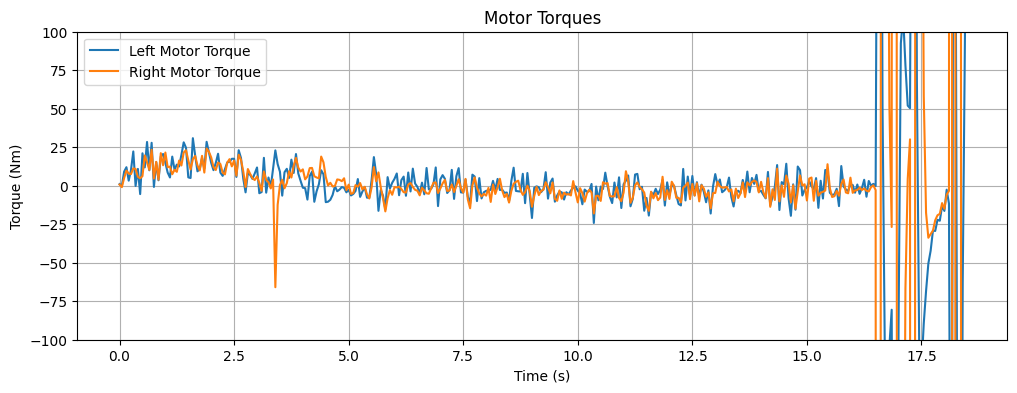

In [110]:
plt.figure(figsize=(12,4))
plt.plot(t, tau_L_arr, label='Left Motor Torque')
plt.plot(t, tau_R_arr, label='Right Motor Torque')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Motor Torques')
plt.legend()
plt.grid(True)
plt.ylim(-100, 100)
plt.show()

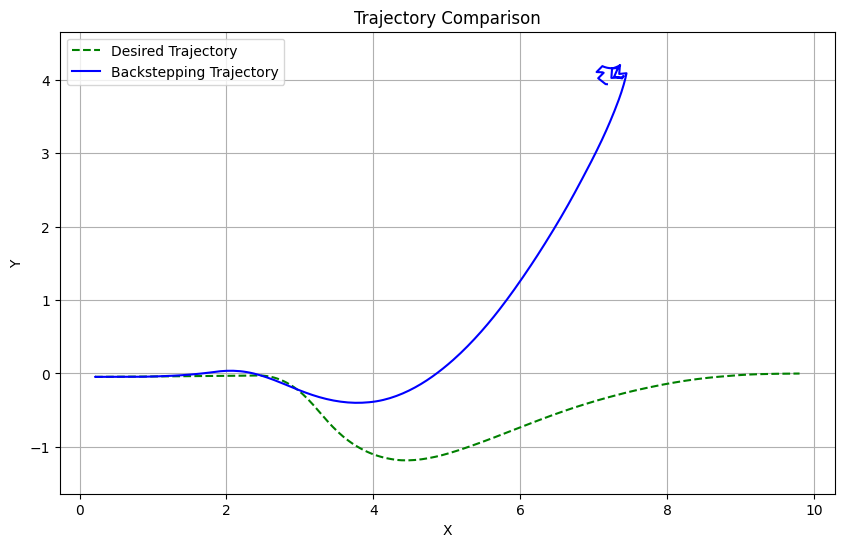

In [111]:
plt.figure(figsize=(10,6))
plt.plot(xy[:,0], xy[:,1], 'g--', label='Desired Trajectory')
plt.plot(xy_real[:,0], xy_real[:,1], 'b-', label='Backstepping Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory Comparison')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# **PD controller**

In [112]:
# --- Robot and Motor Parameters ---
m = 2.0           # mass (kg)
r = 0.05          # wheel radius (m)
w = 0.2           # wheelbase (m)
gamma = 0.15      # motor time constant (s)
dt = 0.05

In [113]:
# --- Reference Trajectory ---
xy = trajectory[:, :2]
N = len(xy)

In [114]:
# Reference velocities and accelerations
v_d = np.zeros(N)
omega_d = np.zeros(N)
dot_v_d = np.zeros(N)
dot_omega_d = np.zeros(N)
theta_d = np.zeros(N)

In [115]:
# --- Compute desired velocities and accelerations ---
for i in range(1, N):
    dx = xy[i, 0] - xy[i - 1, 0]
    dy = xy[i, 1] - xy[i - 1, 1]
    v_d[i] = np.hypot(dx, dy) / dt
    theta_d[i] = np.arctan2(dy, dx)
    if i > 1:
        dtheta = (theta_d[i] - theta_d[i - 1] + np.pi) % (2 * np.pi) - np.pi
        omega_d[i] = dtheta / dt
        dot_v_d[i] = (v_d[i] - v_d[i - 1]) / dt
        dot_omega_d[i] = (omega_d[i] - omega_d[i - 1]) / dt

In [116]:
v_d[0] = 0.0  # Ensure initial desired speed is zero

In [117]:
# --- PD Controller Gains ---
Kp_v = 15.0     # proportional gain for linear speed
Kd_v = 5.0      # derivative gain for linear speed
Kp_omega = 12.0 # proportional gain for angular speed
Kd_omega = 4.0  # derivative gain for angular speed

# --- Simulation State Arrays ---
state = np.zeros((N, 7))  # [x, y, theta, v, omega, tau_L, tau_R]
state[0, :3] = [xy[0, 0], xy[0, 1], theta_d[0]]  # initial pose
v = v_d[0]
omega = omega_d[0]
tau_L = 0.0
tau_R = 0.0

# --- Data Storage ---
v_real = []
omega_real = []
dot_v_real = []
dot_omega_real = []
tau_L_arr = []
tau_R_arr = []
xy_real = []

In [118]:
slip_v = np.random.normal(0, sigma_v)
slip_omega = np.random.normal(0, sigma_omega)

In [119]:
for i in range(1, N):
    # --- Reference ---
    v_ref = v_d[i]
    omega_ref = omega_d[i]
    dot_v_ref = dot_v_d[i]
    dot_omega_ref = dot_omega_d[i]

    # --- Errors ---
    e_v = v - v_ref
    e_omega = omega - omega_ref

    # --- Wheel torques to linear/angular accel ---
    dot_v = (r / (2 * m)) * (tau_L + tau_R)
    dot_omega = (r / (m * w)) * (tau_R - tau_L)


    # --- Derivative of errors (approximated by acceleration error) ---
    e_dot_v = dot_v - dot_v_ref
    e_dot_omega = dot_omega - dot_omega_ref

    # --- PD Control for desired torque derivatives ---
    # Desired torque commands proportional to speed and angular speed errors and their derivatives
    # Compute desired torque sum and difference
    tau_sum_des = -(Kp_v * e_v + Kd_v * e_dot_v) * (2 * m / r)
    tau_diff_des = -(Kp_omega * e_omega + Kd_omega * e_dot_omega) * (m * w / r)

    # Desired torques for left and right wheels
    tau_L_des = 0.5 * (tau_sum_des - tau_diff_des)
    tau_R_des = 0.5 * (tau_sum_des + tau_diff_des)

    # Motor torque derivatives based on first-order lag dynamics (torque derivative equation)
    a_L = gamma * (tau_L_des - tau_L)
    a_R = gamma * (tau_R_des - tau_R)

    # Update motor torques using Euler integration of torque derivative
    tau_L += dt * (1 / gamma) * (-tau_L + a_L)
    tau_R += dt * (1 / gamma) * (-tau_R + a_R)

    # Update robot linear and angular velocities
    dot_v = (r / (2 * m)) * (tau_L + tau_R)
    dot_omega = (r / (m * w)) * (tau_R - tau_L)
    v += dot_v * dt
    omega += dot_omega * dt

    # Update robot pose
    theta = state[i - 1, 2] + omega * dt
    x = state[i - 1, 0] + v * np.cos(theta) * dt
    y = state[i - 1, 1] + v * np.sin(theta) * dt

    state[i] = [x, y, theta, v, omega, tau_L, tau_R]

    # Store data for plotting
    v_real.append(v)
    omega_real.append(omega)
    dot_v_real.append(dot_v)
    dot_omega_real.append(dot_omega)
    tau_L_arr.append(tau_L)
    tau_R_arr.append(tau_R)
    xy_real.append([x, y])

In [120]:
# Convert lists to arrays for plotting
v_real = np.array(v_real)
omega_real = np.array(omega_real)
dot_v_real = np.array(dot_v_real)
dot_omega_real = np.array(dot_omega_real)
tau_L_arr = np.array(tau_L_arr)
tau_R_arr = np.array(tau_R_arr)
xy_real = np.array(xy_real)

In [121]:
t = np.arange(N - 1) * dt

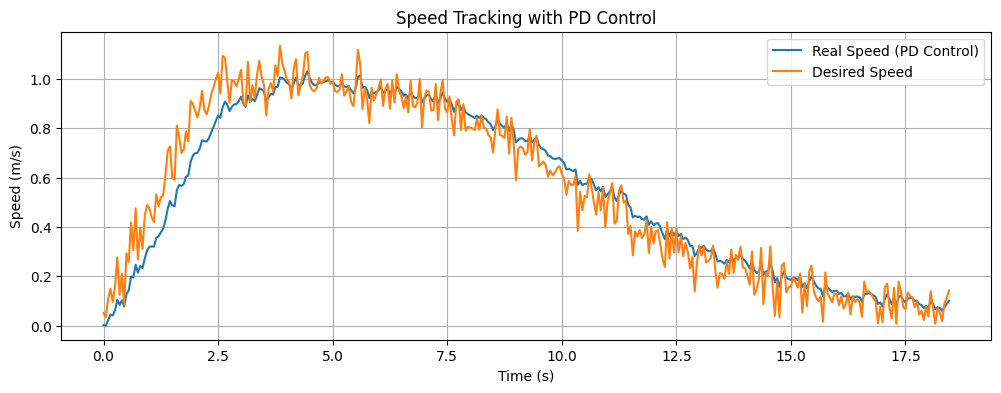

In [122]:
# --- Plot results ---
plt.figure(figsize=(12, 4))
plt.plot(t, v_real, label='Real Speed (PD Control)')
plt.plot(t, v_d[1:], label='Desired Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (m/s)')
plt.title('Speed Tracking with PD Control')
plt.legend()
plt.grid(True)
plt.show()

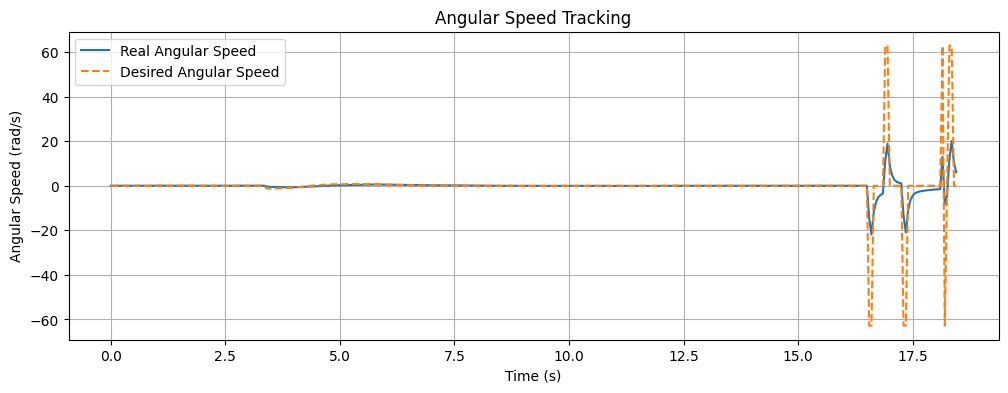

In [123]:
# Angular speed comparison
plt.figure(figsize=(12, 4))
plt.plot(t, omega_real, label='Real Angular Speed')
plt.plot(t, omega_d[1:], label='Desired Angular Speed', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Angular Speed (rad/s)')
plt.title('Angular Speed Tracking')
plt.legend()
plt.grid(True)
plt.show()

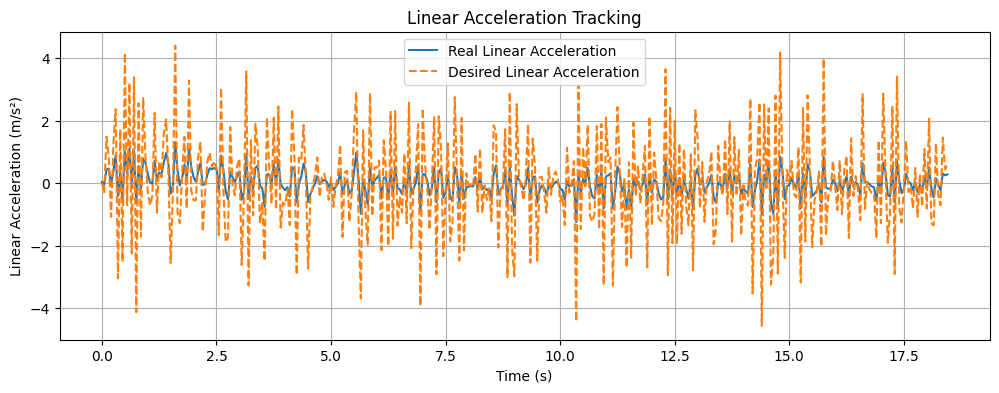

In [124]:
# Linear acceleration comparison
plt.figure(figsize=(12, 4))
plt.plot(t, dot_v_real, label='Real Linear Acceleration')
plt.plot(t, dot_v_d[1:], label='Desired Linear Acceleration', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Linear Acceleration (m/s²)')
plt.title('Linear Acceleration Tracking')
plt.legend()
plt.grid(True)
plt.show()

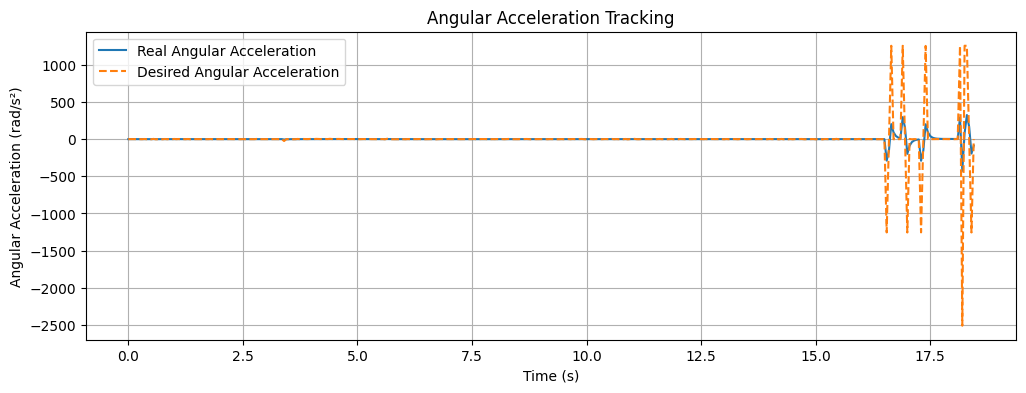

In [125]:
# Angular acceleration comparison
plt.figure(figsize=(12, 4))
plt.plot(t, dot_omega_real, label='Real Angular Acceleration')
plt.plot(t, dot_omega_d[1:], label='Desired Angular Acceleration', linestyle='--')
plt.xlabel('Time (s)')
plt.ylabel('Angular Acceleration (rad/s²)')
plt.title('Angular Acceleration Tracking')
plt.legend()
plt.grid(True)
plt.show()

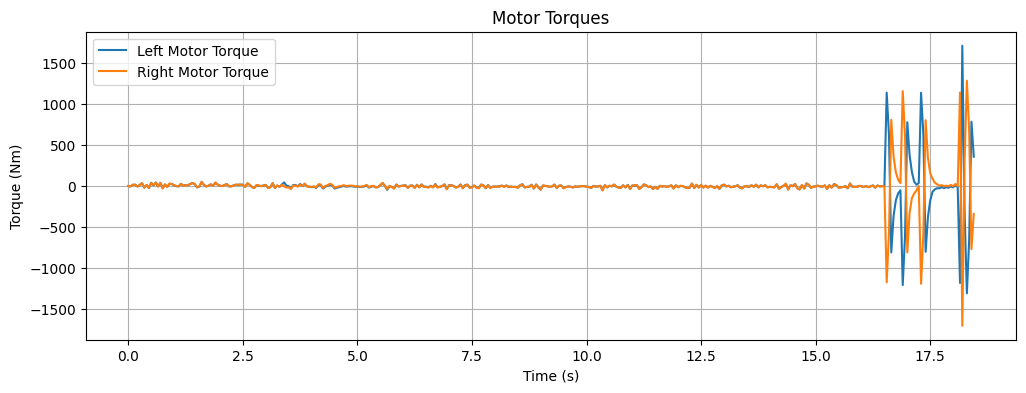

In [126]:
# Motor torques
plt.figure(figsize=(12, 4))
plt.plot(t, tau_L_arr, label='Left Motor Torque')
plt.plot(t, tau_R_arr, label='Right Motor Torque')
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')
plt.title('Motor Torques')
plt.legend()
plt.grid(True)
plt.show()

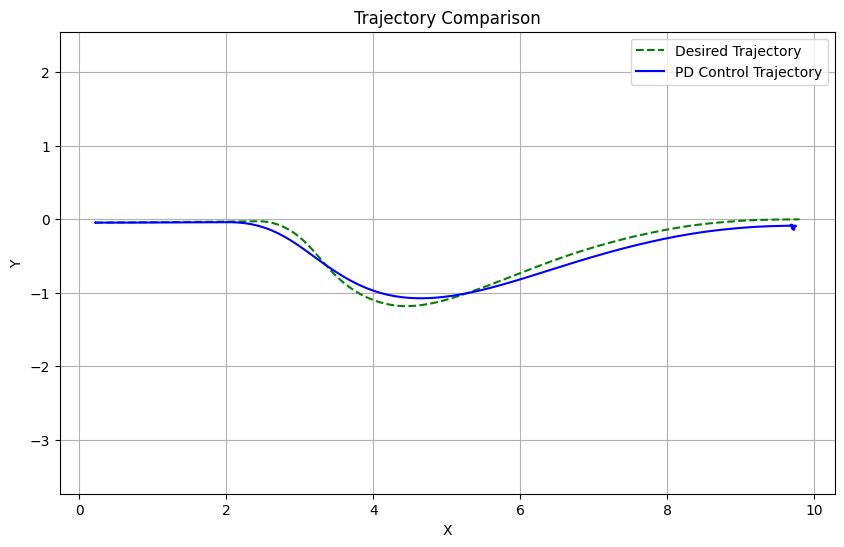

In [127]:
plt.figure(figsize=(10, 6))
plt.plot(xy[:, 0], xy[:, 1], 'g--', label='Desired Trajectory')
plt.plot(xy_real[:, 0], xy_real[:, 1], 'b-', label='PD Control Trajectory')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Trajectory Comparison')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()